# テンプレートマッチング
## 目的
このチュートリアルでは
* テンプレートマッチングを使った画像中の物体検出について学ぶ．
* 次の関数の使い方を学ぶ : [cv2.matchTemplate()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/object_detection.html?highlight=cv2.match#cv2.matchTemplate), [cv2.minMaxLoc()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.minmax#cv2.minMaxLoc)


## 理論
テンプレートマッチングとは画像中に存在するテンプレート画像の位置を発見する方法である．OpenCvは [cv2.matchTemplate()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/object_detection.html?highlight=cv2.match#cv2.matchTemplate) 関数を用意している．この関数はテンプレート画像を入力画像全体にスライド(2D convolutionと同様に)させ，テンプレート画像と画像の注目領域とを比較する．OpenCVではテンプレートと注目領域を比較する方法を幾つか用意している(詳細についてはドキュメントを参照すること)．出力は各画素がテンプレート画像と注目画素の近傍領域の類似度を表すグレースケール画像になる．

入力画像のサイズが $(W \times H)$ ，テンプレート画像のサイズが $(w \times h)$ の時，出力画像のサイズは $(W-w+1, H-h+1)$ になる．テンプレートマッチングをした後は `cv2.minMaxLoc()` 関数を使って，類似度が最大/最小となる画素の位置を調べる．テンプレート画像に最も似ている領域を表す矩形の左上の画素は類似度が最大となる画素の位置，領域のサイズは $(w,h)$ となる．

<font color="blue">Note</font>: 比較方法に `cv2.TM_SQDIFF` を指定した場合，結果の値が小さければ小さいほどテンプレート画像と注目領域が似ていることになるので，使用する時は気をつけよう．


## OpenCVを使ったテンプレートマッチング
ここでは例として，サンプル画像からメッシの顔を探してみる．以下のようなテンプレート画像を作成した:
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/messi_face.jpg)

全ての比較方法を試し，結果がどのようになるか見てみよう: (使用する[画像1](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_template_matching/template.jpg), [画像2](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_template_matching/messi5.jpg))

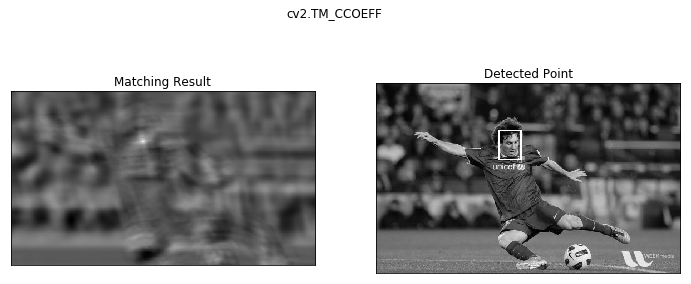

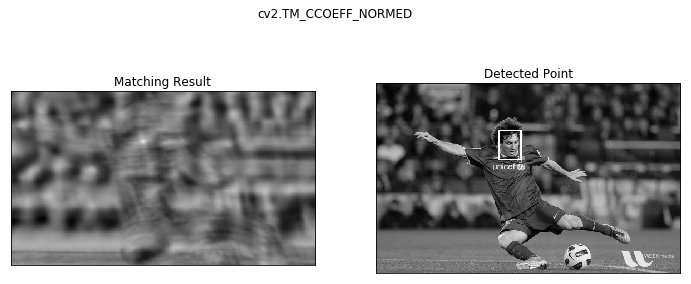

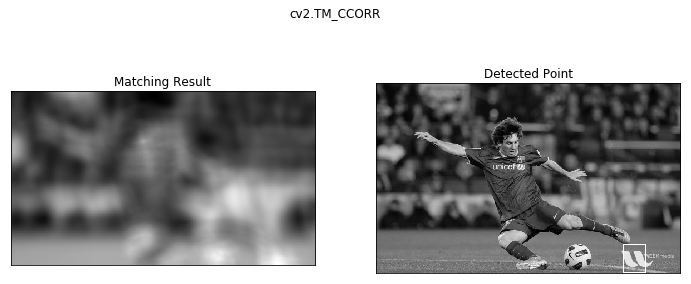

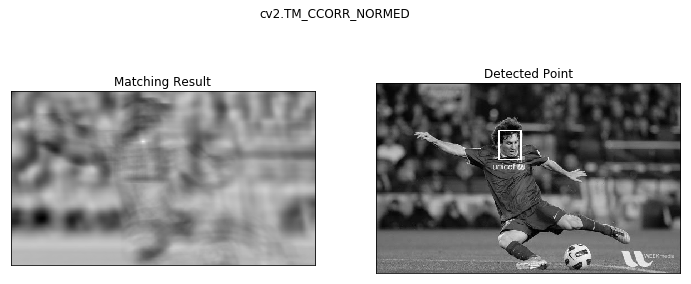

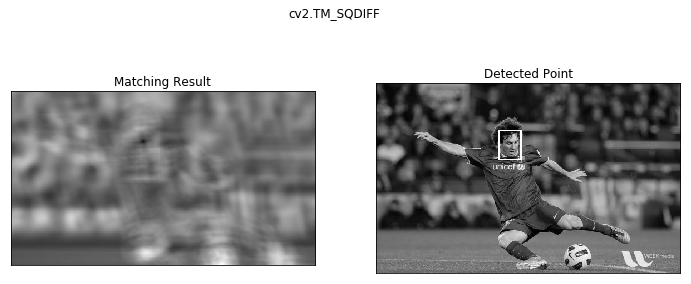

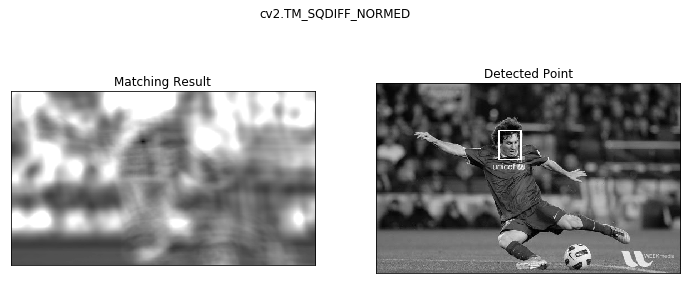

In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)
img2 = img.copy()
template = cv2.imread('template.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.figure(figsize=(12,5))
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

結果を見ると `cv2.TM_CCORR` を指定したときの結果は、期待はずれであった．

## 複数物体のテンプレートマッチング
前章ではメッシの顔を探したが，検出対象は画像中に一つしかないという状況であった．対象物体が画像中に複数個出現するような状況を考えてみよう． `cv2.minMaxLoc()` 関数を使っても全ての物体の位置は検出できない．ここでは有名なゲーム Mario のスクリーンショットからコインを検出する．この場合のキーは[np.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html)である：(使用する[画像1](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_template_matching/mario.jpg), [画像2](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_template_matching/mario_coin.jpg))

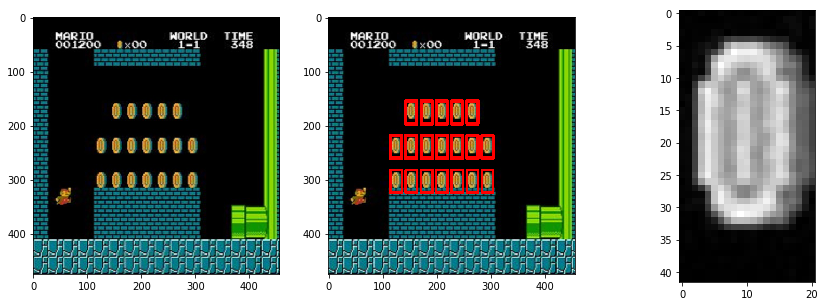

In [11]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_orig = cv2.imread('mario.jpg')
img_rgb = np.copy(img_orig)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('mario_coin.jpg',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

# cv2.imwrite('res.png',img_rgb)
# cv2.imshow("result", img_rgb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_orig)
plt.subplot(1,3,2)
img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(1,3,3)
plt.imshow(template,'gray')
plt.show()

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: OpenCVを使った画像処理
OpenCVが提供する様々な画像処理の関数について学ぶ
* 前の学習項目:  [OpenCVの基底を使った画像の変換 contentsTransforms.ipynb ]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contentsTransforms.html)<BR>
フーリエ変換，コサイン変換などの基底を使った画像変換について学ぶ．
* 次の学習項目: [ハフ変換による直線検出 houghLines.ipynb ]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/houghLines.html)<BR>
画像中の線の検出方法を学ぶ．